## Парсинг шаблонов для эталонных записей

In [ ]:
import os
import pandas as pd
from openpyxl import load_workbook

# Укажите путь к папке с файлами
folder_path = 'Данные'

# Итоговый датафрейм
result_df = pd.DataFrame(columns=['Файл', 'Значение Краткое наименование', 'Значение Полное наименование'])

# Список для хранения сообщений об ошибках
log_messages = []

for root, dirs, files in os.walk(folder_path):  # перебор всех подпапок
    for file in files:
        if file.endswith(('.xlsx', '.xlsm', '.xls')):
            file_path = os.path.join(root, file)
            try:
                wb = load_workbook(file_path, read_only=True, data_only=True)

                # Ищем лист с подстрокой "Эталонные записи" в названии
                sheet_name = None
                for sheet in wb.sheetnames:
                    if "Эталонные записи" in sheet:
                        sheet_name = sheet
                        break

                if sheet_name is None:
                    msg = f'В файле {file} лист с "Эталонные записи" не найден. Пропускаем.'
                    print(msg)
                    log_messages.append(msg)
                    continue

                ws = wb[sheet_name]

                # Находим строку с "Краткое наименование нормализованное" в 3-м столбце (столбец C)
                found_row = None
                for row in ws.iter_rows(min_col=3, max_col=3):
                    cell = row[0]
                    if cell.value == "Краткое наименование нормализованное":
                        found_row = cell.row
                        break

                if found_row is None:
                    msg = f'В листе {sheet_name} файла {file} не найдена ячейка с "Краткое наименование нормализованное". Пропускаем.'
                    print(msg)
                    log_messages.append(msg)
                    continue

                values = []
                current_row = found_row + 2
                while True:
                    cell_value = ws.cell(row=current_row, column=3).value
                    if cell_value is None:
                        if current_row == found_row + 2:
                            msg = f'В листе {sheet_name} файла {file} нет записей "Краткое наименование нормализованное".'
                            print(msg)
                            log_messages.append(msg)
                        break
                    values.append(cell_value)
                    current_row += 1

                # Находим строку с "Полное наименование нормализованное" в 5-м столбце (столбец E)
                found_row = None
                for row in ws.iter_rows(min_col=5, max_col=5):
                    cell = row[0]
                    if cell.value == "Полное наименование нормализованное":
                        found_row = cell.row
                        break

                if found_row is None:
                    msg = f'В листе {sheet_name} файла {file} не найдена ячейка с "Полное наименование нормализованное". Пропускаем.'
                    print(msg)
                    log_messages.append(msg)
                    continue

                values_full = []
                current_row = found_row + 2
                while True:
                    cell_value = ws.cell(row=current_row, column=5).value
                    if cell_value is None:
                        if current_row == found_row + 2:
                            msg = f'В листе {sheet_name} файла {file} нет записей "Полное наименование нормализованное".'
                            print(msg)
                            log_messages.append(msg)    
                        break
                    values_full.append(cell_value)
                    current_row += 1

                # Проверяем, чтобы длина списков совпадала
                min_len = min(len(values), len(values_full))
                if min_len == 0:
                    msg = f'В файле {file} нет данных для "Краткое наименование" или "Полное наименование". Пропускаем.'
                    print(msg)
                    log_messages.append(msg)
                    continue

                # Формируем итоговый датафрейм
                df_temp = pd.DataFrame({
                    'Файл': [file] * min_len,
                    'Значение Краткое наименование': values[:min_len],
                    'Значение Полное наименование': values_full[:min_len]
                })
                result_df = pd.concat([result_df, df_temp], ignore_index=True)

            except Exception as e:
                msg = f'Ошибка при обработке файла {file}: {e}'
                print(msg)
                log_messages.append(msg)

# Сохраняем итоговый датафрейм в Excel
output_path = os.path.join(folder_path, 'собранные_данные.xlsx')
result_df.to_excel(output_path, index=False)
print(f'Сбор данных завершён. Результат сохранён в {output_path}')

# Сохраняем логи в отдельный Excel файл
if log_messages:
    log_df = pd.DataFrame({'Сообщения': log_messages})
    log_path = os.path.join(folder_path, 'логи_обработки.xlsx')
    log_df.to_excel(log_path, index=False)
    print(f'Логи обработки сохранены в {log_path}')
else:
    print('Не обнаружено ошибок и предупреждений.')


## Парсинг нормализованных записей

In [1]:
# Шаг 1: Импорт библиотек
import os
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Шаг 2: Функция для поиска колонок
def find_columns_position(df_sheet, target_columns):
    """
    Ищет позиции целевых колонок в первых двух строках DataFrame
    """
    column_positions = {}
    missing_columns = []
    
    for col_name in target_columns:
        found = False
        for row_idx in range(2):  # Проверяем обе строки
            for col_idx in range(min(40, df_sheet.shape[1])):
                try:
                    cell_value = str(df_sheet.iloc[row_idx, col_idx]).strip()
                    # Для поля "Статус" используем точное сравнение, для остальных - подстроку
                    if col_name == "Статус":
                        if cell_value == "Статус":
                            column_positions[col_name] = col_idx
                            found = True
                            break
                    else:
                        if col_name in cell_value:
                            column_positions[col_name] = col_idx
                            found = True
                            break
                except:
                    continue
            if found:
                break
        
        if not found:
            missing_columns.append(col_name)
    
    return column_positions, missing_columns

In [14]:
# Шаг 3: Основная функция парсинга
def parse_excel_files(root_folder):
    df_parse = pd.DataFrame()
    logs = []
    
    target_columns = [
        "Код КССС/id", 
        "Краткое наименование нормализованное", 
        "Полное наименование нормализованное", 
        "Краткое наименование КССС (исх)",
        "Статус"
    ]
    
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(('.xlsx', '.xls')):
                file_path = os.path.join(root, file)
                folder_name = os.path.basename(root)
                
                try:
                    # Проверяем наличие листа
                    excel_file = pd.ExcelFile(file_path)
                    if "Нормализованные записи" not in excel_file.sheet_names:
                        log_msg = f"Лист 'Нормализованные записи' не найден в файле: {file}"
                        print(log_msg)
                        logs.append({
                            'Тип ошибки': 'Лист не найден',
                            'Файл': file,
                            'Папка': folder_name,
                            'Сообщение': log_msg
                        })
                        continue
                    
                    # Читаем заголовки
                    df_sheet = pd.read_excel(file_path, 
                                           sheet_name="Нормализованные записи", 
                                           header=None, 
                                           nrows=2)
                    
                    # Ищем колонки
                    column_positions, missing_columns = find_columns_position(df_sheet, target_columns)
                    
                    if missing_columns:
                        log_msg = f"Не найдены колонки в файле {file}: {', '.join(missing_columns)}"
                        print(log_msg)
                        logs.append({
                            'Тип ошибки': 'Колонки не найдены',
                            'Файл': file,
                            'Папка': folder_name,
                            'Сообщение': log_msg
                        })
                        continue
                    
                    # Читаем полные данные
                    df_full = pd.read_excel(file_path, 
                                          sheet_name="Нормализованные записи", 
                                          header=None,
                                          skiprows=2)
                    
                    # Собираем данные с проверкой на 5 последовательных пропусков
                    file_data = []
                    consecutive_empty = 0
                    code_col_index = column_positions["Код КССС/id"]
                    
                    for row_idx in range(len(df_full)):
                        try:
                            code_value = df_full.iloc[row_idx, code_col_index]
                            
                            # Проверяем, есть ли данные в ячейке "Код КССС/id"
                            if pd.notna(code_value) and str(code_value).strip() != '':
                                consecutive_empty = 0  # Сбрасываем счетчик пропусков
                                
                                # Преобразуем код в текст, убирая лишние пробелы
                                code_as_text = str(code_value).strip()
                                
                                row_data = {
                                    'Код КССС/id': code_as_text,  # Сохраняем как текст
                                    'Краткое наименование нормализованное': df_full.iloc[row_idx, column_positions["Краткое наименование нормализованное"]] if pd.notna(df_full.iloc[row_idx, column_positions["Краткое наименование нормализованное"]]) else '',
                                    'Полное наименование нормализованное': df_full.iloc[row_idx, column_positions["Полное наименование нормализованное"]] if pd.notna(df_full.iloc[row_idx, column_positions["Полное наименование нормализованное"]]) else '',
                                    'Краткое наименование КССС (исх)': df_full.iloc[row_idx, column_positions["Краткое наименование КССС (исх)"]] if pd.notna(df_full.iloc[row_idx, column_positions["Краткое наименование КССС (исх)"]]) else '',
                                    'Статус': df_full.iloc[row_idx, column_positions["Статус"]] if pd.notna(df_full.iloc[row_idx, column_positions["Статус"]]) else '',
                                    'Папка': folder_name,
                                    'Имя файла': file
                                }
                                file_data.append(row_data)
                            else:
                                consecutive_empty += 1
                                
                            # Если встретили 5 последовательных пропусков, прекращаем обработку этого файла
                            if consecutive_empty >= 5:
                                break
                                
                        except Exception as e:
                            # В случае ошибки чтения строки считаем это пропуском
                            consecutive_empty += 1
                            if consecutive_empty >= 5:
                                break
                            continue
                    
                    if file_data:
                        df_file = pd.DataFrame(file_data)
                        df_parse = pd.concat([df_parse, df_file], ignore_index=True)
                        print(f"✓ Файл {file} обработан, записей: {len(file_data)}")
                    
                except Exception as e:
                    log_msg = f"Ошибка в файле {file}: {str(e)}"
                    print(log_msg)
                    logs.append({
                        'Тип ошибки': 'Ошибка обработки',
                        'Файл': file,
                        'Папка': folder_name,
                        'Сообщение': str(e)
                    })
    
    return df_parse, logs

In [17]:
# Шаг 3: Основная функция парсинга (исправленная часть)
def parse_excel_files(root_folder):
    df_parse = pd.DataFrame()
    logs = []
    
    target_columns = [
        "Код КССС/id", 
        "Краткое наименование нормализованное", 
        "Полное наименование нормализованное", 
        "Краткое наименование КССС (исх)",
        "Статус"
    ]
    
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(('.xlsx', '.xls')):
                file_path = os.path.join(root, file)
                folder_name = os.path.basename(root)
                
                try:
                    # Проверяем наличие листа
                    excel_file = pd.ExcelFile(file_path)
                    if "Нормализованные записи" not in excel_file.sheet_names:
                        log_msg = f"Лист 'Нормализованные записи' не найден в файле: {file}"
                        print(log_msg)
                        logs.append({
                            'Тип ошибки': 'Лист не найден',
                            'Файл': file,
                            'Папка': folder_name,
                            'Сообщение': log_msg
                        })
                        continue
                    
                    # Читаем заголовки с явным указанием типов данных
                    df_sheet = pd.read_excel(file_path, 
                                           sheet_name="Нормализованные записи", 
                                           header=None, 
                                           nrows=2,
                                           dtype=str)  # Читаем все как строку
                    
                    # Ищем колонки
                    column_positions, missing_columns = find_columns_position(df_sheet, target_columns)
                    
                    if missing_columns:
                        log_msg = f"Не найдены колонки в файле {file}: {', '.join(missing_columns)}"
                        print(log_msg)
                        logs.append({
                            'Тип ошибки': 'Колонки не найдены',
                            'Файл': file,
                            'Папка': folder_name,
                            'Сообщение': log_msg
                        })
                        continue
                    
                    # Читаем полные данные как строки чтобы избежать проблем с типами
                    df_full = pd.read_excel(file_path, 
                                          sheet_name="Нормализованные записи", 
                                          header=None,
                                          skiprows=2,
                                          dtype=str)  # Читаем все как строку
                    
                    # Собираем данные с проверкой на 5 последовательных пропусков
                    file_data = []
                    consecutive_empty = 0
                    code_col_index = column_positions["Код КССС/id"]
                    
                    for row_idx in range(len(df_full)):
                        try:
                            # Проверяем что индекс в пределах данных
                            if row_idx >= len(df_full):
                                break
                                
                            # Безопасное получение значения
                            if code_col_index < len(df_full.columns):
                                code_value = df_full.iloc[row_idx, code_col_index]
                            else:
                                code_value = None
                            
                            # Проверяем, есть ли данные в ячейке "Код КССС/id"
                            if pd.notna(code_value) and str(code_value).strip() != '' and code_value is not None:
                                consecutive_empty = 0  # Сбрасываем счетчик пропусков
                                
                                # Безопасное получение остальных значений
                                def get_safe_value(col_name):
                                    if col_name in column_positions and column_positions[col_name] < len(df_full.columns):
                                        value = df_full.iloc[row_idx, column_positions[col_name]]
                                        return str(value).strip() if pd.notna(value) else ''
                                    return ''
                                
                                row_data = {
                                    'Код КССС/id': str(code_value).strip(),
                                    'Краткое наименование нормализованное': get_safe_value("Краткое наименование нормализованное"),
                                    'Полное наименование нормализованное': get_safe_value("Полное наименование нормализованное"),
                                    'Краткое наименование КССС (исх)': get_safe_value("Краткое наименование КССС (исх)"),
                                    'Статус': get_safe_value("Статус"),
                                    'Папка': folder_name,
                                    'Имя файла': file
                                }
                                file_data.append(row_data)
                            else:
                                consecutive_empty += 1
                                
                            # Если встретили 5 последовательных пропусков, прекращаем обработку этого файла
                            if consecutive_empty >= 5:
                                break
                                
                        except Exception as e:
                            # В случае ошибки чтения строки считаем это пропуском
                            consecutive_empty += 1
                            if consecutive_empty >= 5:
                                break
                            continue
                    
                    if file_data:
                        df_file = pd.DataFrame(file_data)
                        df_parse = pd.concat([df_parse, df_file], ignore_index=True)
                        print(f"✓ Файл {file} обработан, записей: {len(file_data)}")
                    
                except Exception as e:
                    log_msg = f"Ошибка в файле {file}: {str(e)}"
                    print(log_msg)
                    logs.append({
                        'Тип ошибки': 'Ошибка обработки',
                        'Файл': file,
                        'Папка': folder_name,
                        'Сообщение': str(e)
                    })
    
    return df_parse, logs

In [20]:
# Шаг 4: Запуск парсинга
root_folder = "Двигатели"  # замените на ваш путь
df_parse, logs = parse_excel_files(root_folder)

# Шаг 5: Сохранение логов
if logs:
    df_logs = pd.DataFrame(logs)
    df_logs.to_excel("Лог.xlsx", index=False)
    print("Логи сохранены в Лог.xlsx")

# Шаг 6: Сохранение результатов
if not df_parse.empty:
    df_parse.to_excel("результат парсинга.xlsx", index=False)
    print("Результат сохранен в 'результат парсинга.xlsx'")
    
    print("\nСтатистика:")
    print(f"Всего записей: {len(df_parse)}")
    print(f"Уникальных файлов: {df_parse['Имя файла'].nunique()}")
    print(f"Уникальных папок: {df_parse['Папка'].nunique()}")
    
    print("\nПервые 5 записей:")
    display(df_parse.head())
else:
    print("Данные не найдены")

Лист 'Нормализованные записи' не найден в файле: 1_Класс-р_мэппинг_Двигатели.xlsx
Ошибка в файле ~$Гидро- и пневмораспределители_59.xlsx: Excel file format cannot be determined, you must specify an engine manually.
Ошибка в файле ~$Насосы гидравл. дгидравл. оборудования_10.xlsx: Excel file format cannot be determined, you must specify an engine manually.
Ошибка в файле ~$Электродвигатели крановые_12.xlsx: Excel file format cannot be determined, you must specify an engine manually.
✓ Файл Вариаторы_1.xlsx обработан, записей: 1
✓ Файл Гидро- и пневмораспределители_59.xlsx обработан, записей: 84
✓ Файл Двигатели внутреннего сгорания поршневые_6.xlsx обработан, записей: 12
✓ Файл Двигатели газотурбинные_6.xlsx обработан, записей: 18
✓ Файл Двигатели гидравлические_4.xlsx обработан, записей: 4
✓ Файл Механизмы исполнительные пневматические_1.xlsx обработан, записей: 3
✓ Файл Механизмы исполнительные электрические_17.xlsx обработан, записей: 36
✓ Файл Мотор-редукторы_18.xlsx обработан, запис

,Код КССС/id,Краткое наименование нормализованное,Полное наименование нормализованное,Краткое наименование КССС (исх),Статус,Папка,Имя файла
0,1058475,"Вариатор V0,5 9,2кВт","Вариатор V0,5 9,2кВт 1400об/мин","Вариатор Bonfiglioli V 0,5 F D14 P71",Эталон,Двигатели,Вариаторы_1.xlsx
1,3528879,Электропневм. Aventics 5/2 5811170650,Электропневмопереключатель Aventics 5/2 581117...,Электропневмоперекл. Aventics 5811170650,Эталон,Двигатели,Гидро- и пневмораспределители_59.xlsx
2,3528346,Электропневм. Aventics 5/2 5811290650,Электропневмопереключатель Aventics 5/2 581129...,Электропневмоперекл. Aventics 5811290650,Эталон,Двигатели,Гидро- и пневмораспределители_59.xlsx
3,3528347,Электропневм. Aventics 5/2 5811130000,Электропневмопереключатель Aventics 5/2 581113...,Электропневмоперекл. Aventics 5811130000,Эталон,Двигатели,Гидро- и пневмораспределители_59.xlsx
4,1771395,Клапан Aventics 5/2 5811130000,Клапан пневматический Festo VL-5/2-D-1-FR-C-EX...,Клапан Festo VL-5/2-D-1-FR-C-EX 536010,Эталон,Двигатели,Гидро- и пневмораспределители_59.xlsx


In [23]:
# Шаг 1: Замена пустых значений в колонке "Статус" на "На блокирование"
df_parse['Статус'] = df_parse['Статус'].fillna('На блокирование')
# Также заменяем пустые строки
df_parse['Статус'] = df_parse['Статус'].replace(['', ' ','Блокировка','блокирование'], 'На блокирование')

print("=== ОБРАБОТКА ДАТАФРЕЙМА ===")
print(f"Всего строк в датафрейме: {len(df_parse)}")

=== ОБРАБОТКА ДАТАФРЕЙМА ===
Всего строк в датафрейме: 3325


In [24]:
# Шаг 2: Отчет по значениям в столбце "Статус"
print("\n=== ОТЧЕТ ПО СТАТУСАМ ===")
status_counts = df_parse['Статус'].value_counts()
print("Распределение значений в столбце 'Статус':")
for status, count in status_counts.items():
    percentage = (count / len(df_parse)) * 100
    print(f"  {status}: {count} записей ({percentage:.1f}%)")


=== ОТЧЕТ ПО СТАТУСАМ ===
Распределение значений в столбце 'Статус':
  Эталон: 1820 записей (54.7%)
  На блокирование: 1505 записей (45.3%)


Text(0.5, 1.0, 'Доля статусов')

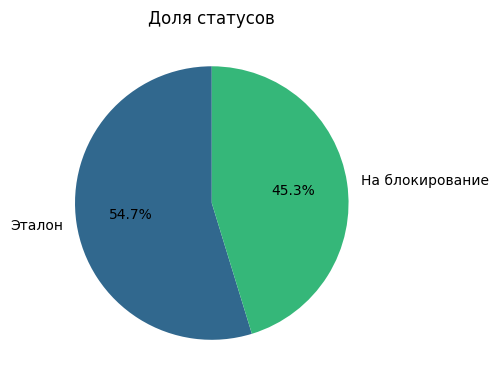

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
# Альтернативная версия графиков с seaborn
plt.figure(figsize=(15, 5))
# График 2: Круговая диаграмма
plt.subplot(1, 3, 2)
plt.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette('viridis', len(status_counts)))
plt.title('Доля статусов')

In [26]:
# Шаг 4: Отчет по записям со статусом "Эталон"
print("\n=== ОТЧЕТ ПО СТАТУСУ 'ЭТАЛОН' ===")
etalon_df = df_parse[df_parse['Статус'] == 'Эталон']
print(f"Всего записей со статусом 'Эталон': {len(etalon_df)}")

# Записи с пустыми значениями в колонках наименований
empty_short_name = etalon_df['Краткое наименование нормализованное'].isna() | (etalon_df['Краткое наименование нормализованное'] == '')
empty_full_name = etalon_df['Полное наименование нормализованное'].isna() | (etalon_df['Полное наименование нормализованное'] == '')

empty_both = empty_short_name & empty_full_name
empty_either = empty_short_name | empty_full_name

print(f"Записей с пустым 'Краткое наименование нормализованное': {empty_short_name.sum()}")
print(f"Записей с пустым 'Полное наименование нормализованное': {empty_full_name.sum()}")
print(f"Записей с пустыми обоими наименованиями: {empty_both.sum()}")
print(f"Записей с хотя бы одним пустым наименованием: {empty_either.sum()}")


=== ОТЧЕТ ПО СТАТУСУ 'ЭТАЛОН' ===
Всего записей со статусом 'Эталон': 1820
Записей с пустым 'Краткое наименование нормализованное': 0
Записей с пустым 'Полное наименование нормализованное': 0
Записей с пустыми обоими наименованиями: 0
Записей с хотя бы одним пустым наименованием: 0


In [27]:
# Детальный отчет
if empty_either.sum() > 0:
    print("\nДетальная информация о записях с пустыми наименованиями:")
    problematic_records = etalon_df[empty_either]
    
    for idx, row in problematic_records.head(10).iterrows():  # Показываем первые 10 записей
        short_empty = "ПУСТО" if empty_short_name[idx] else "заполнено"
        full_empty = "ПУСТО" if empty_full_name[idx] else "заполнено"
        print(f"  Код: {row['Код КССС/id']} | Краткое: {short_empty} | Полное: {full_empty} | Файл: {row['Имя файла']}")
    
    if len(problematic_records) > 10:
        print(f"  ... и еще {len(problematic_records) - 10} записей")

# Дополнительная статистика
print(f"\n=== ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА ===")
print(f"Всего уникальных файлов: {df_parse['Имя файла'].nunique()}")
print(f"Всего уникальных папок: {df_parse['Папка'].nunique()}")
print(f"Всего уникальных кодов: {df_parse['Код КССС/id'].nunique()}")

# Сохранение обработанного датафрейма
df_parse.to_excel("результат парсинга с обработкой.xlsx", index=False)
print(f"\nОбработанный датафрейм сохранен в файл: 'результат парсинга с обработкой.xlsx'")


=== ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА ===
Всего уникальных файлов: 28
Всего уникальных папок: 1
Всего уникальных кодов: 2249

Обработанный датафрейм сохранен в файл: 'результат парсинга с обработкой.xlsx'


=== АНАЛИЗ ЗАПИСЕЙ СО СТАТУСОМ 'ЭТАЛОН' ===
Всего записей со статусом 'Эталон': 1820
Уникальных кодов 'Код КССС/id': 1260

=== АНАЛИЗ НЕУНИКАЛЬНЫХ ЗАПИСЕЙ ===
Кодов с дубликатами (больше 1 записи): 553

Детальная информация по дубликатам:
  Различные файлы: ['Части, дет. двигат., прив.,мех. прочие_489.xlsx', 'Части, дет. двигат., прив.,мех. прочие_506.xlsx']
  Различные файлы: ['Части, дет. двигат., прив.,мех. прочие_489.xlsx', 'Части, дет. двигат., прив.,мех. прочие_506.xlsx']
  Различные файлы: ['Части, дет. двигат., прив.,мех. прочие_489.xlsx', 'Части, дет. двигат., прив.,мех. прочие_506.xlsx']
  Различные файлы: ['Станки-качалки_2.xlsx', 'Станки-качалки_38.xlsx']
  Различные файлы: ['Станки-качалки_2.xlsx', 'Станки-качалки_38.xlsx']
  Различные файлы: ['Части, дет. двигат., прив.,мех. прочие_489.xlsx', 'Части, дет. двигат., прив.,мех. прочие_506.xlsx']
  Различные файлы: ['Части, дет. двигат., прив.,мех. прочие_489.xlsx', 'Части, дет. двигат., прив.,мех. прочие_506.xlsx']
  Различн

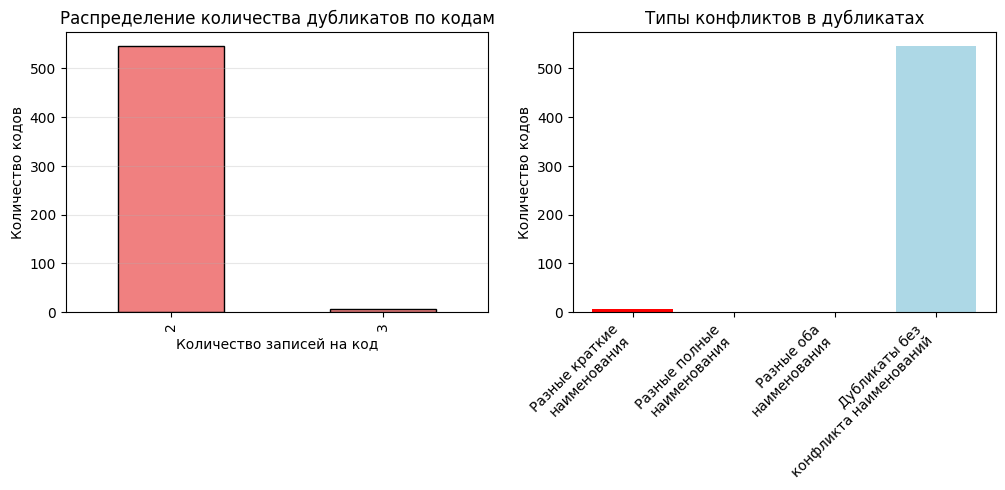

In [32]:
# Анализ записей со статусом "Эталон"
print("=== АНАЛИЗ ЗАПИСЕЙ СО СТАТУСОМ 'ЭТАЛОН' ===")

# Фильтруем записи со статусом "Эталон"
etalon_df = df_parse[df_parse['Статус'] == 'Эталон'].copy()

print(f"Всего записей со статусом 'Эталон': {len(etalon_df)}")
print(f"Уникальных кодов 'Код КССС/id': {etalon_df['Код КССС/id'].nunique()}")

# Анализ неуникальных записей
print("\n=== АНАЛИЗ НЕУНИКАЛЬНЫХ ЗАПИСЕЙ ===")

# Группируем по коду и считаем количество уникальных значений в каждой колонке
duplicate_analysis = etalon_df.groupby('Код КССС/id').agg({
    'Краткое наименование нормализованное': 'nunique',
    'Полное наименование нормализованное': 'nunique', 
    'Имя файла': 'nunique',
    'Папка': 'nunique',
    'Статус': 'count'  # общее количество записей с этим кодом
}).reset_index()

# Переименовываем колонки для понятности
duplicate_analysis.columns = [
    'Код КССС/id', 
    'Уникальных_кратких_наименований', 
    'Уникальных_полных_наименований',
    'Уникальных_файлов',
    'Уникальных_папок', 
    'Всего_записей'
]

# Находим коды с дубликатами (больше 1 записи)
duplicate_codes = duplicate_analysis[duplicate_analysis['Всего_записей'] > 1]
print(f"Кодов с дубликатами (больше 1 записи): {len(duplicate_codes)}")

# Детальный анализ дубликатов
if len(duplicate_codes) > 0:
    print("\nДетальная информация по дубликатам:")
    for _, row in duplicate_codes.iterrows():
        code = row['Код КССС/id']
        code_records = etalon_df[etalon_df['Код КССС/id'] == code]
        
        #print(f"\nКод: {code}")
        #print(f"  Всего записей: {row['Всего_записей']}")
        #print(f"  Уникальных кратких наименований: {row['Уникальных_кратких_наименований']}")
        #print(f"  Уникальных полных наименований: {row['Уникальных_полных_наименований']}")
        #print(f"  Уникальных файлов: {row['Уникальных_файлов']}")
        #print(f"  Уникальных папок: {row['Уникальных_папок']}")
        
        # Выводим различные значения для этого кода
        unique_short_names = code_records['Краткое наименование нормализованное'].unique()
        unique_full_names = code_records['Полное наименование нормализованное'].unique()
        unique_files = code_records['Имя файла'].unique()
        
        if len(unique_short_names) > 1:
            print(f"  Различные краткие наименования: {list(unique_short_names)}")
        if len(unique_full_names) > 1:
            print(f"  Различные полные наименования: {list(unique_full_names)}")
        if len(unique_files) > 1:
            print(f"  Различные файлы: {list(unique_files)}")

# Создаем датафрейм с детальной информацией о дубликатах
detailed_duplicates = []

for code in duplicate_codes['Код КССС/id']:
    code_records = etalon_df[etalon_df['Код КССС/id'] == code]
    
    for idx, record in code_records.iterrows():
        detailed_duplicates.append({
            'Код КССС/id': code,
            'Краткое наименование нормализованное': record['Краткое наименование нормализованное'],
            'Полное наименование нормализованное': record['Полное наименование нормализованное'],
            'Имя файла': record['Имя файла'],
            'Папка': record['Папка'],
            'Всего_дубликатов_по_коду': len(code_records),
            'Уникальных_кратких_наименований': code_records['Краткое наименование нормализованное'].nunique(),
            'Уникальных_полных_наименований': code_records['Полное наименование нормализованное'].nunique(),
            'Уникальных_файлов': code_records['Имя файла'].nunique()
        })

# Создаем итоговый датафрейм с дубликатами
df_duplicates = pd.DataFrame(detailed_duplicates)

# Сохраняем в Excel
if len(df_duplicates) > 0:
    df_duplicates.to_excel('дубликаты_эталон.xlsx', index=False)
    print(f"\nДанные о дубликатах сохранены в файл: 'дубликаты_эталон.xlsx'")
    print(f"Всего записей в файле дубликатов: {len(df_duplicates)}")
else:
    print("\nДубликаты не найдены")

# Сводная статистика по дубликатам
if len(duplicate_codes) > 0:
    print("\n=== СВОДНАЯ СТАТИСТИКА ПО ДУБЛИКАТАМ ===")
    print(f"Всего проблемных кодов: {len(duplicate_codes)}")
    print(f"Общее количество записей с дубликатами: {duplicate_codes['Всего_записей'].sum()}")
    
    # Анализ конфликтов в наименованиях
    conflicts_short = duplicate_codes[duplicate_codes['Уникальных_кратких_наименований'] > 1]
    conflicts_full = duplicate_codes[duplicate_codes['Уникальных_полных_наименований'] > 1]
    conflicts_both = duplicate_codes[
        (duplicate_codes['Уникальных_кратких_наименований'] > 1) & 
        (duplicate_codes['Уникальных_полных_наименований'] > 1)
    ]
    
    print(f"Кодов с разными краткими наименованиями: {len(conflicts_short)}")
    print(f"Кодов с разными полными наименованиями: {len(conflicts_full)}")
    print(f"Кодов с разными обоими наименованиями: {len(conflicts_both)}")
    
    # Визуализация статистики дубликатов
    plt.figure(figsize=(12, 8))
    
    # График 1: Распределение количества дубликатов по кодам
    plt.subplot(2, 2, 1)
    duplicate_counts = duplicate_codes['Всего_записей'].value_counts().sort_index()
    duplicate_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
    plt.title('Распределение количества дубликатов по кодам')
    plt.xlabel('Количество записей на код')
    plt.ylabel('Количество кодов')
    plt.grid(axis='y', alpha=0.3)
    
    # График 2: Типы конфликтов в дубликатах
    plt.subplot(2, 2, 2)
    conflict_types = {
        'Разные краткие\nнаименования': len(conflicts_short),
        'Разные полные\nнаименования': len(conflicts_full),
        'Разные оба\nнаименования': len(conflicts_both),
        'Дубликаты без\nконфликта наименований': len(duplicate_codes) - len(conflicts_short) - len(conflicts_full) + len(conflicts_both)
    }
    plt.bar(conflict_types.keys(), conflict_types.values(), color=['red', 'orange', 'darkred', 'lightblue'])
    plt.title('Типы конфликтов в дубликатах')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Количество кодов')
    
    

print("\nАнализ завершен!")

In [38]:
import pandas as pd
import os

def load_and_process_excel_file(file_path):
    """
    Загружает и обрабатывает Excel файл с указанной структурой
    """
    try:
        # Читаем файл
        df = pd.read_excel(file_path)
        
        # Сохраняем имя файла
        file_name = os.path.basename(file_path)
        
        # Удаляем вторую строку (индекс 0)
        df = df.drop(0, errors='ignore').reset_index(drop=True)
        
        # Список колонок для сохранения
        target_columns = [
            'Hierarchy_MTR_Class',
            'Hierarchy_MTR_Name', 
            'CSCD_ID',
            'SHORT_NAME/ru_RU',
            'FULL_NAME/ru_RU',
            'TMC_Stat',
            'TMC_Type',
            'COMMENT',
            'AUTO_SHORT_NAME',
            'AUTO_FULL_NAME'
        ]
        
        # Оставляем только нужные колонки (если они существуют)
        existing_columns = [col for col in target_columns if col in df.columns]
        df = df[existing_columns]
        
        # Добавляем колонку с именем файла
        df['source_file'] = file_name
        
        print(f"Файл '{file_name}' успешно загружен. Колонки: {list(df.columns)}")
        return df
        
    except Exception as e:
        print(f"Ошибка при загрузке файла {file_path}: {str(e)}")
        return None

def add_excel_files_to_dataframe(initial_df=None):
    """
    Функция для добавления Excel файлов к датафрейму
    """
    if initial_df is None:
        df_combined = pd.DataFrame()
    else:
        df_combined = initial_df.copy()
    
    while True:
        print("\n" + "="*50)
        print("ДОБАВЛЕНИЕ EXCEL ФАЙЛОВ")
        print("="*50)
        print("1 - Добавить файл")
        print("2 - Завершить добавление и показать результат")
        
        choice = input("Выберите действие (1 или 2): ").strip()
        
        if choice == '1':
            file_path = input("Введите путь к Excel файлу: ").strip()
            
            if not os.path.exists(file_path):
                print("Файл не существует!")
                continue
                
            new_df = load_and_process_excel_file(file_path)
            
            if new_df is not None:
                if df_combined.empty:
                    df_combined = new_df
                else:
                    # Проверяем совпадение структуры колонок
                    if set(df_combined.columns) == set(new_df.columns):
                        df_combined = pd.concat([df_combined, new_df], ignore_index=True)
                        print(f"Файл добавлен. Всего записей: {len(df_combined)}")
                    else:
                        print("Ошибка: структура колонок не совпадает с основным датафреймом!")
                        print(f"Ожидаемые колонки: {list(df_combined.columns)}")
                        print(f"Фактические колонки: {list(new_df.columns)}")
                        
        elif choice == '2':
            break
        else:
            print("Неверный выбор!")
    
    return df_combined

# Основной блок выполнения
print("=== ЗАГРУЗКА ВТОРОГО ДАТАФРЕЙМА ===")


=== ЗАГРУЗКА ВТОРОГО ДАТАФРЕЙМА ===


In [40]:
# Вариант 1: Загрузка одного файла
file_path = input("Движки.xlsx").strip()
#file_path = "Движки.xlsx"

if os.path.exists(file_path):
    df_second = load_and_process_excel_file(file_path)
    
    if df_second is not None:
        # Вариант 2: Добавление дополнительных файлов
        df_second = add_excel_files_to_dataframe(df_second)
        
        # Вывод информации о датафрейме
        print("\n" + "="*50)
        print("ИТОГОВЫЙ ДАТАФРЕЙМ")
        print("="*50)
        print(f"Размер датафрейма: {df_second.shape}")
        print(f"Колонки: {list(df_second.columns)}")
        print(f"Уникальных файлов-источников: {df_second['source_file'].nunique()}")
        
        # Статистика по файлам-источникам
        if not df_second.empty:
            print("\nРаспределение по файлам-источникам:")
            file_stats = df_second['source_file'].value_counts()
            for file, count in file_stats.items():
                print(f"  {file}: {count} записей")
            
            # Показываем первые строки
            print("\nПервые 5 строк датафрейма:")
            display(df_second.head())
            
            # Сохранение объединенного датафрейма (опционально)
            save_choice = input("\nСохранить объединенный датафрейм в файл? (y/n): ").strip().lower()
            if save_choice == 'y':
                output_file = "объединенный_датафрейм.xlsx"
                df_second.to_excel(output_file, index=False)
                print(f"Датафрейм сохранен в файл: {output_file}")
else:
    print("Указанный файл не существует!")
    df_second = None

Файл 'Движки.xlsx' успешно загружен. Колонки: ['Hierarchy_MTR_Class', 'Hierarchy_MTR_Name', 'CSCD_ID', 'SHORT_NAME/ru_RU', 'FULL_NAME/ru_RU', 'TMC_Stat', 'TMC_Type', 'COMMENT', 'AUTO_SHORT_NAME', 'AUTO_FULL_NAME', 'source_file']

ДОБАВЛЕНИЕ EXCEL ФАЙЛОВ
1 - Добавить файл
2 - Завершить добавление и показать результат

ИТОГОВЫЙ ДАТАФРЕЙМ
Размер датафрейма: (1738, 11)
Колонки: ['Hierarchy_MTR_Class', 'Hierarchy_MTR_Name', 'CSCD_ID', 'SHORT_NAME/ru_RU', 'FULL_NAME/ru_RU', 'TMC_Stat', 'TMC_Type', 'COMMENT', 'AUTO_SHORT_NAME', 'AUTO_FULL_NAME', 'source_file']
Уникальных файлов-источников: 1

Распределение по файлам-источникам:
  Движки.xlsx: 1738 записей

Первые 5 строк датафрейма:


,Hierarchy_MTR_Class,Hierarchy_MTR_Name,CSCD_ID,SHORT_NAME/ru_RU,FULL_NAME/ru_RU,TMC_Stat,TMC_Type,COMMENT,AUTO_SHORT_NAME,AUTO_FULL_NAME,source_file
0,980600000000000,"ДХНО Двигатели, приводы и мех. исп.",6007539,Электродвигатель ВАО2-560-1000-2У2,Электродвигатель взрывозащищенный асинхронный ...,00,2,NaN,NaN,NaN,Движки.xlsx
1,2020010301000000,Двигатели внутреннего сгорания поршневые,3718663,Двигатель LIFAN C195FD-A 6A,Двигатель дизельный LIFAN C195FD-A 6A,00,3,NaN,NaN,NaN,Движки.xlsx
2,980600000000000,"ДХНО Двигатели, приводы и мех. исп.",1779983,"Электродвигатель ВА160M4 18,5 б/у","Электродвигатель ВА160M4 18,5 б/у",00,4,NaN,NaN,NaN,Движки.xlsx
3,2020010301000000,Двигатели внутреннего сгорания поршневые,3033508,Мотор лодочный Yamaha F25GMHS,Мотор лодочный Yamaha F25GMHS,00,3,NaN,NaN,NaN,Движки.xlsx
4,2020010301000000,Двигатели внутреннего сгорания поршневые,3033516,Мотор лодочный Suzuki DT 9.9 AS,Мотор лодочный Suzuki DT 9.9 AS,00,3,NaN,NaN,NaN,Движки.xlsx


In [41]:
# Фильтрация записей с подстрокой "Эталон" или "эталон" в поле COMMENT
print("=== ФИЛЬТРАЦИЯ ЗАПИСЕЙ С 'ЭТАЛОН' В COMMENT ===")

if df_second is not None and not df_second.empty:
    # Проверяем наличие колонки COMMENT в датафрейме
    if 'COMMENT' in df_second.columns:
        # Создаем маску для фильтрации
        mask = df_second['COMMENT'].notna() & (
            df_second['COMMENT'].str.contains('Эталон', case=False, na=False) |
            df_second['COMMENT'].str.contains('эталон', case=False, na=False)
        )
        
        # Альтернативный более простой вариант (учитывает регистр):
        # mask = df_second['COMMENT'].notna() & df_second['COMMENT'].str.contains('эталон', case=False, na=False)
        
        # Применяем фильтр
        df_ksss_etalon = df_second[mask].copy()
        
        print(f"Всего записей в исходном датафрейме: {len(df_second)}")
        print(f"Найдено записей с 'Эталон' в COMMENT: {len(df_ksss_etalon)}")
        
        if not df_ksss_etalon.empty:
            print(f"\nКолонки в df_ksss_etalon: {list(df_ksss_etalon.columns)}")
            
            # Показываем примеры найденных комментариев
            print("\nПримеры найденных комментариев:")
            for idx, comment in enumerate(df_ksss_etalon['COMMENT'].head(5)):
                print(f"  {idx+1}. {comment}")
            
            # Статистика по источникам
            print(f"\nРаспределение по файлам-источникам:")
            source_stats = df_ksss_etalon['source_file'].value_counts()
            for file, count in source_stats.items():
                print(f"  {file}: {count} записей")
            
            # Дополнительная информация о найденных записях
            print(f"\nДополнительная статистика:")
            print(f"Уникальных CSCD_ID: {df_ksss_etalon['CSCD_ID'].nunique()}")
            print(f"Уникальных файлов-источников: {df_ksss_etalon['source_file'].nunique()}")
            
            # Показываем первые строки отфильтрованного датафрейма
            print("\nПервые 5 строк df_ksss_etalon:")
            display(df_ksss_etalon.head())
            
            # Сохраняем в Excel файл (опционально)
            save_choice = input("\nСохранить df_ksss_etalon в файл? (y/n): ").strip().lower()
            if save_choice == 'y':
                output_file = "df_ksss_etalon.xlsx"
                df_ksss_etalon.to_excel(output_file, index=False)
                print(f"Датафрейм сохранен в файл: {output_file}")
        else:
            print("Записей с 'Эталон' в COMMENT не найдено!")
            df_ksss_etalon = pd.DataFrame()
    else:
        print("Колонка 'COMMENT' не найдена в датафрейме!")
        print(f"Доступные колонки: {list(df_second.columns)}")
        df_ksss_etalon = pd.DataFrame()
else:
    print("Исходный датафрейм пуст или не загружен!")
    df_ksss_etalon = pd.DataFrame()

=== ФИЛЬТРАЦИЯ ЗАПИСЕЙ С 'ЭТАЛОН' В COMMENT ===
Всего записей в исходном датафрейме: 1738
Найдено записей с 'Эталон' в COMMENT: 1030

Колонки в df_ksss_etalon: ['Hierarchy_MTR_Class', 'Hierarchy_MTR_Name', 'CSCD_ID', 'SHORT_NAME/ru_RU', 'FULL_NAME/ru_RU', 'TMC_Stat', 'TMC_Type', 'COMMENT', 'AUTO_SHORT_NAME', 'AUTO_FULL_NAME', 'source_file']

Примеры найденных комментариев:
  1. Эталонная запись
  2. Эталонная запись
  3. Эталонная запись
  4. Эталонная запись
  5. Эталонная запись

Распределение по файлам-источникам:
  Движки.xlsx: 1030 записей

Дополнительная статистика:
Уникальных CSCD_ID: 1030
Уникальных файлов-источников: 1

Первые 5 строк df_ksss_etalon:


,Hierarchy_MTR_Class,Hierarchy_MTR_Name,CSCD_ID,SHORT_NAME/ru_RU,FULL_NAME/ru_RU,TMC_Stat,TMC_Type,COMMENT,AUTO_SHORT_NAME,AUTO_FULL_NAME,source_file
60,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",6064683,Бак топливный TOHATSU M5B 369-70316-4,Бак топливный артикул TOHATSU M5B 369-70316-4,00,3,Эталонная запись,Бак топливный TOHATSU M5B 369-70316-4,Бак топливный артикул TOHATSU M5B 369-70316-4,Движки.xlsx
61,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",6064684,Батарея Cummins 0249-0821,Батарея артикул Cummins 0249-0821,00,3,Эталонная запись,Батарея Cummins 0249-0821,Батарея артикул Cummins 0249-0821,Движки.xlsx
62,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",6064685,Батарея Cummins 0300-5795,Батарея артикул Cummins 0300-5795,00,3,Эталонная запись,Батарея Cummins 0300-5795,Батарея артикул Cummins 0300-5795,Движки.xlsx
63,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",6064686,Блок питанияWIT81635 Rotork,Блок питания для приводаWIT81635 Rotork,00,3,Эталонная запись,Блок питанияWIT81635 Rotork,Блок питания для приводаWIT81635 Rotork,Движки.xlsx
64,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",6064687,Блок сцепления Arrow XA-5079,Блок сцепления для двигателя артикулArrow C-66...,00,3,Эталонная запись,Блок сцепления Arrow XA-5079,Блок сцепления для двигателя артикулArrow C-66...,Движки.xlsx


In [42]:
# Сравнение датафреймов etalon_df и df_ksss_etalon
print("=== СРАВНЕНИЕ ДАТАФРЕЙМОВ ===")
print(f"Размер etalon_df: {etalon_df.shape if etalon_df is not None else 'не загружен'}")
print(f"Размер df_ksss_etalon: {df_ksss_etalon.shape if df_ksss_etalon is not None else 'не загружен'}")

# Проверяем, что оба датафрейма загружены и не пусты
if etalon_df is not None and not etalon_df.empty and df_ksss_etalon is not None and not df_ksss_etalon.empty:
    
    # Создаем копии для безопасной работы
    etalon_clean = etalon_df.copy()
    ksss_clean = df_ksss_etalon.copy()
    
    # Предварительная обработка данных - удаляем пробелы и приводим к строковому типу
    # Для etalon_df
    etalon_clean['Полное наименование нормализованное'] = etalon_clean['Полное наименование нормализованное'].astype(str).str.strip()
    etalon_clean['Краткое наименование нормализованное'] = etalon_clean['Краткое наименование нормализованное'].astype(str).str.strip()
    etalon_clean['Код КССС/id'] = etalon_clean['Код КССС/id'].astype(str).str.strip()
    
    # Для df_ksss_etalon
    ksss_clean['FULL_NAME/ru_RU'] = ksss_clean['FULL_NAME/ru_RU'].astype(str).str.strip()
    ksss_clean['SHORT_NAME/ru_RU'] = ksss_clean['SHORT_NAME/ru_RU'].astype(str).str.strip()
    if 'CSCD_ID' in ksss_clean.columns:
        ksss_clean['CSCD_ID'] = ksss_clean['CSCD_ID'].astype(str).str.strip()
    
    # Создаем список для совпавших записей
    matched_records = []
    
    print("\nПоиск совпадений...")
    
    # Проходим по каждой записи в etalon_df
    for idx, etalon_row in etalon_clean.iterrows():
        etalon_full_name = etalon_row['Полное наименование нормализованное']
        etalon_short_name = etalon_row['Краткое наименование нормализованное']
        etalon_code = etalon_row['Код КССС/id']
        
        # Ищем совпадения по полному наименованию
        full_name_matches = ksss_clean[ksss_clean['FULL_NAME/ru_RU'] == etalon_full_name]
        
        if not full_name_matches.empty:
            # Найдено совпадение по полному наименованию
            for _, ksss_row in full_name_matches.iterrows():
                matched_record = {
                    # Данные из etalon_df
                    'Код КССС/id_etalon': etalon_code,
                    'Полное наименование нормализованное_etalon': etalon_full_name,
                    'Краткое наименование нормализованное_etalon': etalon_short_name,
                    'Статус_etalon': etalon_row['Статус'],
                    'Папка_etalon': etalon_row['Папка'],
                    'Имя файла_etalon': etalon_row['Имя файла'],
                    
                    # Данные из df_ksss_etalon
                    'CSCD_ID_ksss': ksss_row.get('CSCD_ID', ''),
                    'FULL_NAME/ru_RU_ksss': ksss_row.get('FULL_NAME/ru_RU', ''),
                    'SHORT_NAME/ru_RU_ksss': ksss_row.get('SHORT_NAME/ru_RU', ''),
                    'TMC_Stat_ksss': ksss_row.get('TMC_Stat', ''),
                    'TMC_Type_ksss': ksss_row.get('TMC_Type', ''),
                    'COMMENT_ksss': ksss_row.get('COMMENT', ''),
                    'AUTO_SHORT_NAME_ksss': ksss_row.get('AUTO_SHORT_NAME', ''),
                    'AUTO_FULL_NAME_ksss': ksss_row.get('AUTO_FULL_NAME', ''),
                    'Hierarchy_MTR_Class_ksss': ksss_row.get('Hierarchy_MTR_Class', ''),
                    'Hierarchy_MTR_Name_ksss': ksss_row.get('Hierarchy_MTR_Name', ''),
                    'source_file_ksss': ksss_row.get('source_file', ''),
                    
                    # Информация о типе совпадения
                    'Тип_совпадения': 'Полное наименование'
                }
                matched_records.append(matched_record)
        
        else:
            # Если нет совпадения по полному наименованию, ищем по краткому
            short_name_matches = ksss_clean[ksss_clean['SHORT_NAME/ru_RU'] == etalon_short_name]
            
            if not short_name_matches.empty:
                # Найдено совпадение по краткому наименованию
                for _, ksss_row in short_name_matches.iterrows():
                    matched_record = {
                        # Данные из etalon_df
                        'Код КССС/id_etalon': etalon_code,
                        'Полное наименование нормализованное_etalon': etalon_full_name,
                        'Краткое наименование нормализованное_etalon': etalon_short_name,
                        'Статус_etalon': etalon_row['Статус'],
                        'Папка_etalon': etalon_row['Папка'],
                        'Имя файла_etalon': etalon_row['Имя файла'],
                        
                        # Данные из df_ksss_etalon
                        'CSCD_ID_ksss': ksss_row.get('CSCD_ID', ''),
                        'FULL_NAME/ru_RU_ksss': ksss_row.get('FULL_NAME/ru_RU', ''),
                        'SHORT_NAME/ru_RU_ksss': ksss_row.get('SHORT_NAME/ru_RU', ''),
                        'TMC_Stat_ksss': ksss_row.get('TMC_Stat', ''),
                        'TMC_Type_ksss': ksss_row.get('TMC_Type', ''),
                        'COMMENT_ksss': ksss_row.get('COMMENT', ''),
                        'AUTO_SHORT_NAME_ksss': ksss_row.get('AUTO_SHORT_NAME', ''),
                        'AUTO_FULL_NAME_ksss': ksss_row.get('AUTO_FULL_NAME', ''),
                        'Hierarchy_MTR_Class_ksss': ksss_row.get('Hierarchy_MTR_Class', ''),
                        'Hierarchy_MTR_Name_ksss': ksss_row.get('Hierarchy_MTR_Name', ''),
                        'source_file_ksss': ksss_row.get('source_file', ''),
                        
                        # Информация о типе совпадения
                        'Тип_совпадения': 'Краткое наименование'
                    }
                    matched_records.append(matched_record)
    
    # Создаем итоговый датафрейм
    if matched_records:
        df_full_match = pd.DataFrame(matched_records)
        
        print(f"\nРЕЗУЛЬТАТЫ СРАВНЕНИЯ:")
        print(f"Всего записей в etalon_df: {len(etalon_clean)}")
        print(f"Найдено совпадений: {len(df_full_match)}")
        
        # Анализ типов совпадений
        match_types = df_full_match['Тип_совпадения'].value_counts()
        print(f"\nТипы совпадений:")
        for match_type, count in match_types.items():
            print(f"  {match_type}: {count}")
        
        # Уникальные совпадения (по кодам из etalon_df)
        unique_etalon_codes = df_full_match['Код КССС/id_etalon'].nunique()
        print(f"Уникальных кодов из etalon_df с совпадениями: {unique_etalon_codes}")
        
        # Уникальные совпадения (по кодам из ksss)
        if 'CSCD_ID_ksss' in df_full_match.columns:
            unique_ksss_codes = df_full_match['CSCD_ID_ksss'].nunique()
            print(f"Уникальных кодов из df_ksss_etalon с совпадениями: {unique_ksss_codes}")
        
        # Сохраняем в Excel файл
        output_filename = "результат_совпадений.xlsx"
        df_full_match.to_excel(output_filename, index=False)
        print(f"\nРезультат сохранен в файл: {output_filename}")
        
        # Показываем первые строки результата
        print(f"\nПервые 5 строк df_full_match:")
        display(df_full_match.head())
        
        # Дополнительная статистика
        print(f"\nДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:")
        print(f"Колонки в результате: {list(df_full_match.columns)}")
        
        # Распределение по файлам-источникам
        if 'source_file_ksss' in df_full_match.columns:
            print(f"\nРаспределение совпадений по файлам-источникам:")
            source_stats = df_full_match['source_file_ksss'].value_counts()
            for file, count in source_stats.head(10).items():  # Показываем топ-10
                print(f"  {file}: {count}")
        
    else:
        print("Совпадений не найдено!")
        df_full_match = pd.DataFrame()

else:
    print("Один или оба датафрейма пусты или не загружены!")
    df_full_match = pd.DataFrame()

=== СРАВНЕНИЕ ДАТАФРЕЙМОВ ===
Размер etalon_df: (1820, 7)
Размер df_ksss_etalon: (1030, 11)

Поиск совпадений...

РЕЗУЛЬТАТЫ СРАВНЕНИЯ:
Всего записей в etalon_df: 1820
Найдено совпадений: 521

Типы совпадений:
  Полное наименование: 521
Уникальных кодов из etalon_df с совпадениями: 521
Уникальных кодов из df_ksss_etalon с совпадениями: 521

Результат сохранен в файл: результат_совпадений.xlsx

Первые 5 строк df_full_match:


,Код КССС/id_etalon,Полное наименование нормализованное_etalon,Краткое наименование нормализованное_etalon,Статус_etalon,Папка_etalon,Имя файла_etalon,CSCD_ID_ksss,FULL_NAME/ru_RU_ksss,SHORT_NAME/ru_RU_ksss,TMC_Stat_ksss,TMC_Type_ksss,COMMENT_ksss,AUTO_SHORT_NAME_ksss,AUTO_FULL_NAME_ksss,Hierarchy_MTR_Class_ksss,Hierarchy_MTR_Name_ksss,source_file_ksss,Тип_совпадения
0,1770447,Двигатель газотурбинный ПС-90ГП-25А,Двигатель газотурбинный ПС-90ГП-25А,Эталон,Двигатели,Двигатели газотурбинные_6.xlsx,6056643,Двигатель газотурбинный ПС-90ГП-25А,Двигатель газотурбинный ПС-90ГП-25А,00,3,Эталонная запись,Двигатель газотурбинный ПС-90ГП-25А,Двигатель газотурбинный ПС-90ГП-25А,2020010302000000,Двигатели газотурбинные,Движки.xlsx,Полное наименование
1,1659908,Двигатель газотурбинный Д-30ЭУ-6,Двигатель газотурбинный Д-30ЭУ-6,Эталон,Двигатели,Двигатели газотурбинные_6.xlsx,6056644,Двигатель газотурбинный Д-30ЭУ-6,Двигатель газотурбинный Д-30ЭУ-6,00,3,Эталонная запись,Двигатель газотурбинный Д-30ЭУ-6,Двигатель газотурбинный Д-30ЭУ-6,2020010302000000,Двигатели газотурбинные,Движки.xlsx,Полное наименование
2,708743,Двигатель газотурбинный ПС-90ГП-1,Двигатель газотурбинный ПС-90ГП-1,Эталон,Двигатели,Двигатели газотурбинные_6.xlsx,6056645,Двигатель газотурбинный ПС-90ГП-1,Двигатель газотурбинный ПС-90ГП-1,00,3,Эталонная запись,Двигатель газотурбинный ПС-90ГП-1,Двигатель газотурбинный ПС-90ГП-1,2020010302000000,Двигатели газотурбинные,Движки.xlsx,Полное наименование
3,3312802,Двигатель газотурбинный ПС-90ЭУ-16А,Двигатель газотурбинный ПС-90ЭУ-16А,Эталон,Двигатели,Двигатели газотурбинные_6.xlsx,6056646,Двигатель газотурбинный ПС-90ЭУ-16А,Двигатель газотурбинный ПС-90ЭУ-16А,00,3,Эталонная запись,Двигатель газотурбинный ПС-90ЭУ-16А,Двигатель газотурбинный ПС-90ЭУ-16А,2020010302000000,Двигатели газотурбинные,Движки.xlsx,Полное наименование
4,1000068,Двигатель газотурбинный ПС-90ГП-3,Двигатель газотурбинный ПС-90ГП-3,Эталон,Двигатели,Двигатели газотурбинные_6.xlsx,6056647,Двигатель газотурбинный ПС-90ГП-3,Двигатель газотурбинный ПС-90ГП-3,00,3,Эталонная запись,Двигатель газотурбинный ПС-90ГП-3,Двигатель газотурбинный ПС-90ГП-3,2020010302000000,Двигатели газотурбинные,Движки.xlsx,Полное наименование



ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:
Колонки в результате: ['Код КССС/id_etalon', 'Полное наименование нормализованное_etalon', 'Краткое наименование нормализованное_etalon', 'Статус_etalon', 'Папка_etalon', 'Имя файла_etalon', 'CSCD_ID_ksss', 'FULL_NAME/ru_RU_ksss', 'SHORT_NAME/ru_RU_ksss', 'TMC_Stat_ksss', 'TMC_Type_ksss', 'COMMENT_ksss', 'AUTO_SHORT_NAME_ksss', 'AUTO_FULL_NAME_ksss', 'Hierarchy_MTR_Class_ksss', 'Hierarchy_MTR_Name_ksss', 'source_file_ksss', 'Тип_совпадения']

Распределение совпадений по файлам-источникам:
  Движки.xlsx: 521


=== СОЗДАНИЕ ДАТАФРЕЙМОВ С НЕСОПОСТАВЛЕННЫМИ ЗАПИСЯМИ ===
Используем информацию из df_full_match для поиска несопоставленных записей...

СТАТИСТИКА НЕСОПОСТАВЛЕННЫХ ЗАПИСЕЙ:
Всего записей в etalon_df: 1820
Несопоставленных записей из etalon_df: 1299
Всего записей в df_ksss_etalon: 1030
Несопоставленных записей из df_ksss_etalon: 509

Несопоставленные записи из etalon_df сохранены в файл: 'несопоставленные_записи_etalon.xlsx'

Первые 5 несопоставленных записей из etalon_df:


,Код КССС/id,Краткое наименование нормализованное,Полное наименование нормализованное,Краткое наименование КССС (исх),Статус,Папка,Имя файла
0,1058475,"Вариатор V0,5 9,2кВт","Вариатор V0,5 9,2кВт 1400об/мин","Вариатор Bonfiglioli V 0,5 F D14 P71",Эталон,Двигатели,Вариаторы_1.xlsx
1,3528879,Электропневм. Aventics 5/2 5811170650,Электропневмопереключатель Aventics 5/2 581117...,Электропневмоперекл. Aventics 5811170650,Эталон,Двигатели,Гидро- и пневмораспределители_59.xlsx
2,3528346,Электропневм. Aventics 5/2 5811290650,Электропневмопереключатель Aventics 5/2 581129...,Электропневмоперекл. Aventics 5811290650,Эталон,Двигатели,Гидро- и пневмораспределители_59.xlsx
3,3528347,Электропневм. Aventics 5/2 5811130000,Электропневмопереключатель Aventics 5/2 581113...,Электропневмоперекл. Aventics 5811130000,Эталон,Двигатели,Гидро- и пневмораспределители_59.xlsx
4,1771395,Клапан Aventics 5/2 5811130000,Клапан пневматический Festo VL-5/2-D-1-FR-C-EX...,Клапан Festo VL-5/2-D-1-FR-C-EX 536010,Эталон,Двигатели,Гидро- и пневмораспределители_59.xlsx


Несопоставленные записи из df_ksss_etalon сохранены в файл: 'несопоставленные_записи_ksss.xlsx'

Первые 5 несопоставленных записей из df_ksss_etalon:


,Hierarchy_MTR_Class,Hierarchy_MTR_Name,CSCD_ID,SHORT_NAME/ru_RU,FULL_NAME/ru_RU,TMC_Stat,TMC_Type,COMMENT,AUTO_SHORT_NAME,AUTO_FULL_NAME,source_file
60,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",6064683,Бак топливный TOHATSU M5B 369-70316-4,Бак топливный артикул TOHATSU M5B 369-70316-4,00,3,Эталонная запись,Бак топливный TOHATSU M5B 369-70316-4,Бак топливный артикул TOHATSU M5B 369-70316-4,Движки.xlsx
61,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",6064684,Батарея Cummins 0249-0821,Батарея артикул Cummins 0249-0821,00,3,Эталонная запись,Батарея Cummins 0249-0821,Батарея артикул Cummins 0249-0821,Движки.xlsx
62,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",6064685,Батарея Cummins 0300-5795,Батарея артикул Cummins 0300-5795,00,3,Эталонная запись,Батарея Cummins 0300-5795,Батарея артикул Cummins 0300-5795,Движки.xlsx
63,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",6064686,Блок питанияWIT81635 Rotork,Блок питания для приводаWIT81635 Rotork,00,3,Эталонная запись,Блок питанияWIT81635 Rotork,Блок питания для приводаWIT81635 Rotork,Движки.xlsx
64,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",6064687,Блок сцепления Arrow XA-5079,Блок сцепления для двигателя артикулArrow C-66...,00,3,Эталонная запись,Блок сцепления Arrow XA-5079,Блок сцепления для двигателя артикулArrow C-66...,Движки.xlsx



=== АНАЛИЗ НЕСОПОСТАВЛЕННЫХ ЗАПИСЕЙ ===
АНАЛИЗ НЕСОПОСТАВЛЕННЫХ ЗАПИСЕЙ ИЗ etalon_df:
Уникальных кодов: 739
Уникальных файлов-источников: 23
Записей с пустым полным наименованием: 0
Записей с пустым кратким наименованием: 0

АНАЛИЗ НЕСОПОСТАВЛЕННЫХ ЗАПИСЕЙ ИЗ df_ksss_etalon:
Уникальных кодов CSCD_ID: 509
Уникальных файлов-источников: 1

Распределение статусов в несопоставленных записях:
  00: 509 (100.0%)


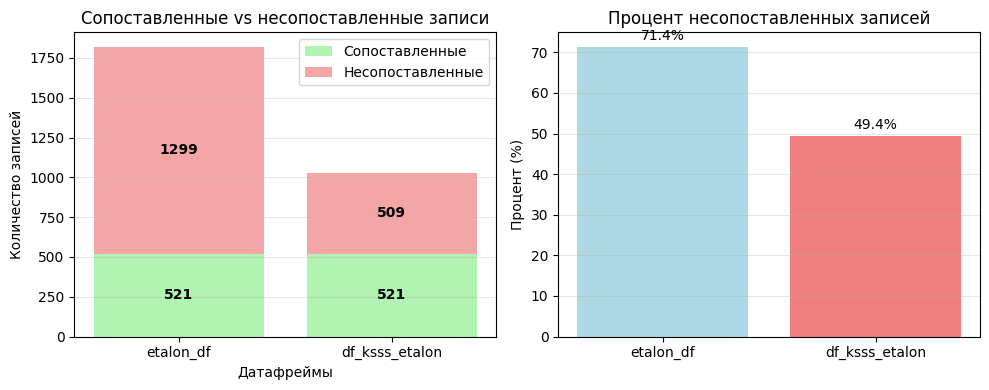

In [45]:
# Создание датафреймов с несопоставленными записями
print("=== СОЗДАНИЕ ДАТАФРЕЙМОВ С НЕСОПОСТАВЛЕННЫМИ ЗАПИСЯМИ ===")

# Проверяем, что оба исходных датафрейма загружены
if etalon_df is not None and not etalon_df.empty and df_ksss_etalon is not None and not df_ksss_etalon.empty:
    
    # Создаем копии для безопасной работы
    etalon_clean = etalon_df.copy()
    ksss_clean = df_ksss_etalon.copy()
    
    # Предварительная обработка данных (аналогично предыдущему коду)
    etalon_clean['Полное наименование нормализованное'] = etalon_clean['Полное наименование нормализованное'].astype(str).str.strip()
    etalon_clean['Краткое наименование нормализованное'] = etalon_clean['Краткое наименование нормализованное'].astype(str).str.strip()
    etalon_clean['Код КССС/id'] = etalon_clean['Код КССС/id'].astype(str).str.strip()
    
    ksss_clean['FULL_NAME/ru_RU'] = ksss_clean['FULL_NAME/ru_RU'].astype(str).str.strip()
    ksss_clean['SHORT_NAME/ru_RU'] = ksss_clean['SHORT_NAME/ru_RU'].astype(str).str.strip()
    if 'CSCD_ID' in ksss_clean.columns:
        ksss_clean['CSCD_ID'] = ksss_clean['CSCD_ID'].astype(str).str.strip()
    
    # Создаем множества для быстрого поиска совпавших записей
    matched_etalon_full_names = set()
    matched_etalon_short_names = set()
    matched_ksss_full_names = set()
    matched_ksss_short_names = set()
    
    # Заполняем множества на основе df_full_match
    if 'df_full_match' in globals() and not df_full_match.empty:
        print("Используем информацию из df_full_match для поиска несопоставленных записей...")
        
        # Собираем все совпавшие наименования из etalon_df
        if 'Полное наименование нормализованное_etalon' in df_full_match.columns:
            matched_etalon_full_names = set(df_full_match['Полное наименование нормализованное_etalon'].dropna().unique())
        if 'Краткое наименование нормализованное_etalon' in df_full_match.columns:
            matched_etalon_short_names = set(df_full_match['Краткое наименование нормализованное_etalon'].dropna().unique())
        
        # Собираем все совпавшие наименования из df_ksss_etalon
        if 'FULL_NAME/ru_RU_ksss' in df_full_match.columns:
            matched_ksss_full_names = set(df_full_match['FULL_NAME/ru_RU_ksss'].dropna().unique())
        if 'SHORT_NAME/ru_RU_ksss' in df_full_match.columns:
            matched_ksss_short_names = set(df_full_match['SHORT_NAME/ru_RU_ksss'].dropna().unique())
    
    else:
        print("df_full_match не найден, выполняем поиск совпадений заново...")
        # Если df_full_match не создан, выполняем поиск совпадений
        for idx, etalon_row in etalon_clean.iterrows():
            etalon_full_name = etalon_row['Полное наименование нормализованное']
            etalon_short_name = etalon_row['Краткое наименование нормализованное']
            
            # Проверяем совпадения по полному наименованию
            full_name_matches = ksss_clean[ksss_clean['FULL_NAME/ru_RU'] == etalon_full_name]
            if not full_name_matches.empty:
                matched_etalon_full_names.add(etalon_full_name)
                matched_ksss_full_names.update(full_name_matches['FULL_NAME/ru_RU'].unique())
            
            # Проверяем совпадения по краткому наименованию
            short_name_matches = ksss_clean[ksss_clean['SHORT_NAME/ru_RU'] == etalon_short_name]
            if not short_name_matches.empty:
                matched_etalon_short_names.add(etalon_short_name)
                matched_ksss_short_names.update(short_name_matches['SHORT_NAME/ru_RU'].unique())
    
    # Создаем датафреймы с несопоставленными записями
    
    # 1. Несопоставленные записи из etalon_df
    unmatched_etalon_mask = ~(
        etalon_clean['Полное наименование нормализованное'].isin(matched_etalon_full_names) |
        etalon_clean['Краткое наименование нормализованное'].isin(matched_etalon_short_names)
    )
    
    df_unmatched_etalon = etalon_clean[unmatched_etalon_mask].copy()
    
    # 2. Несопоставленные записи из df_ksss_etalon
    unmatched_ksss_mask = ~(
        ksss_clean['FULL_NAME/ru_RU'].isin(matched_ksss_full_names) |
        ksss_clean['SHORT_NAME/ru_RU'].isin(matched_ksss_short_names)
    )
    
    df_unmatched_ksss = ksss_clean[unmatched_ksss_mask].copy()
    
    # Выводим статистику
    print(f"\nСТАТИСТИКА НЕСОПОСТАВЛЕННЫХ ЗАПИСЕЙ:")
    print(f"Всего записей в etalon_df: {len(etalon_clean)}")
    print(f"Несопоставленных записей из etalon_df: {len(df_unmatched_etalon)}")
    print(f"Всего записей в df_ksss_etalon: {len(ksss_clean)}")
    print(f"Несопоставленных записей из df_ksss_etalon: {len(df_unmatched_ksss)}")
    
    # Сохраняем датафреймы в Excel файлы
    if not df_unmatched_etalon.empty:
        df_unmatched_etalon.to_excel("несопоставленные_записи_etalon.xlsx", index=False)
        print(f"\nНесопоставленные записи из etalon_df сохранены в файл: 'несопоставленные_записи_etalon.xlsx'")
        
        # Показываем первые строки
        print("\nПервые 5 несопоставленных записей из etalon_df:")
        display(df_unmatched_etalon.head())
    else:
        print("\nВсе записи из etalon_df были сопоставлены!")
    
    if not df_unmatched_ksss.empty:
        df_unmatched_ksss.to_excel("несопоставленные_записи_ksss.xlsx", index=False)
        print(f"Несопоставленные записи из df_ksss_etalon сохранены в файл: 'несопоставленные_записи_ksss.xlsx'")
        
        # Показываем первые строки
        print("\nПервые 5 несопоставленных записей из df_ksss_etalon:")
        display(df_unmatched_ksss.head())
    else:
        print("Все записи из df_ksss_etalon были сопоставлены!")
    
    # Дополнительный анализ несопоставленных записей
    print(f"\n=== АНАЛИЗ НЕСОПОСТАВЛЕННЫХ ЗАПИСЕЙ ===")
    
    if not df_unmatched_etalon.empty:
        print("АНАЛИЗ НЕСОПОСТАВЛЕННЫХ ЗАПИСЕЙ ИЗ etalon_df:")
        print(f"Уникальных кодов: {df_unmatched_etalon['Код КССС/id'].nunique()}")
        print(f"Уникальных файлов-источников: {df_unmatched_etalon['Имя файла'].nunique()}")
        
        # Проверяем наличие пустых наименований
        empty_full_names = df_unmatched_etalon['Полное наименование нормализованное'].isin(['', 'nan', 'None'])
        empty_short_names = df_unmatched_etalon['Краткое наименование нормализованное'].isin(['', 'nan', 'None'])
        
        print(f"Записей с пустым полным наименованием: {empty_full_names.sum()}")
        print(f"Записей с пустым кратким наименованием: {empty_short_names.sum()}")
    
    if not df_unmatched_ksss.empty:
        print("\nАНАЛИЗ НЕСОПОСТАВЛЕННЫХ ЗАПИСЕЙ ИЗ df_ksss_etalon:")
        print(f"Уникальных кодов CSCD_ID: {df_unmatched_ksss['CSCD_ID'].nunique() if 'CSCD_ID' in df_unmatched_ksss.columns else 'N/A'}")
        print(f"Уникальных файлов-источников: {df_unmatched_ksss['source_file'].nunique()}")
        
        # Анализ статусов
        if 'TMC_Stat' in df_unmatched_ksss.columns:
            print(f"\nРаспределение статусов в несопоставленных записях:")
            stat_counts = df_unmatched_ksss['TMC_Stat'].value_counts()
            for stat, count in stat_counts.items():
                percentage = (count / len(df_unmatched_ksss)) * 100
                print(f"  {stat}: {count} ({percentage:.1f}%)")
    
    # Визуализация результатов
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # График 1: Сопоставленные vs несопоставленные записи
    categories = ['etalon_df', 'df_ksss_etalon']
    matched_counts = [
        len(etalon_clean) - len(df_unmatched_etalon),
        len(ksss_clean) - len(df_unmatched_ksss)
    ]
    unmatched_counts = [
        len(df_unmatched_etalon),
        len(df_unmatched_ksss)
    ]
    
    x = range(len(categories))
    ax1.bar(x, matched_counts, label='Сопоставленные', color='lightgreen', alpha=0.7)
    ax1.bar(x, unmatched_counts, bottom=matched_counts, label='Несопоставленные', color='lightcoral', alpha=0.7)
    
    ax1.set_title('Сопоставленные vs несопоставленные записи')
    ax1.set_xlabel('Датафреймы')
    ax1.set_ylabel('Количество записей')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Добавляем подписи значений
    for i, (matched, unmatched) in enumerate(zip(matched_counts, unmatched_counts)):
        ax1.text(i, matched/2, f'{matched}', ha='center', va='center', fontweight='bold')
        ax1.text(i, matched + unmatched/2, f'{unmatched}', ha='center', va='center', fontweight='bold')
    
    # График 2: Процент несопоставленных записей
    unmatched_percentages = [
        (len(df_unmatched_etalon) / len(etalon_clean)) * 100,
        (len(df_unmatched_ksss) / len(ksss_clean)) * 100
    ]
    
    bars = ax2.bar(categories, unmatched_percentages, color=['lightblue', 'lightcoral'])
    ax2.set_title('Процент несопоставленных записей')
    ax2.set_ylabel('Процент (%)')
    ax2.grid(axis='y', alpha=0.3)
    
    # Добавляем подписи значений на столбцы
    for bar, percentage in zip(bars, unmatched_percentages):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{percentage:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

else:
    print("Один или оба исходных датафрейма пусты или не загружены!")
    df_unmatched_etalon = pd.DataFrame()
    df_unmatched_ksss = pd.DataFrame()

=== НЕЧЕТКОЕ СРАВНЕНИЕ НЕСОПОСТАВЛЕННЫХ ЗАПИСЕЙ ===
fuzzywuzzy успешно импортирован
Записей для нечеткого сравнения:
  etalon_df с полными наименованиями: 1299
  etalon_df с краткими наименованиями: 1299
  ksss с полными наименованиями: 509
  ksss с краткими наименованиями: 509

Начинаем нечеткое сравнение с порогом 85%...
Поиск соответствий по полным наименованиям...
Поиск соответствий по кратким наименованиям...

РЕЗУЛЬТАТЫ НЕЧЕТКОГО СРАВНЕНИЯ:
Найдено соответствий по полным наименованиям: 1605
Найдено соответствий по кратким наименованиям: 1089
Всего потенциальных соответствий: 2694

Создан датафрейм df_part_match с 1661 записями

СТАТИСТИКА НЕЧЕТКИХ СОВПАДЕНИЙ:
Средний процент совпадения: 95.9%
Максимальный процент совпадения: 100.0%
Минимальный процент совпадения: 85.0%

Распределение по типам совпадений:
  Полное наименование: 1537
  Краткое наименование: 124

Распределение по качеству совпадений:
  85-89%: 200
  90-94%: 448
  95-100%: 283

Результат сохранен в файл: частичные_со

,Код КССС/id_etalon,Полное наименование нормализованное_etalon,Краткое наименование нормализованное_etalon,Статус_etalon,Папка_etalon,Имя файла_etalon,CSCD_ID_ksss,FULL_NAME/ru_RU_ksss,SHORT_NAME/ru_RU_ksss,TMC_Stat_ksss,...,AUTO_SHORT_NAME_ksss,AUTO_FULL_NAME_ksss,Hierarchy_MTR_Class_ksss,Hierarchy_MTR_Name_ksss,source_file_ksss,Тип_совпадения,Процент_совпадения,Сопоставленный_текст_etalon,Сопоставленный_текст_ksss,score_range
0,5003635,Бак топливный TOHATSU артикул M5B 369-70316-4,Бак топливн. TOHATSU арт.M5B 369-70316-4,Эталон,Двигатели,"Части, дет. двигат., прив.,мех. прочие_489.xlsx",6064683,Бак топливный артикул TOHATSU M5B 369-70316-4,Бак топливный TOHATSU M5B 369-70316-4,00,...,Бак топливный TOHATSU M5B 369-70316-4,Бак топливный артикул TOHATSU M5B 369-70316-4,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",Движки.xlsx,Полное наименование,100,Бак топливный TOHATSU артикул M5B 369-70316-4,Бак топливный артикул TOHATSU M5B 369-70316-4,NaN
601,1400974,Стартер Waukesha артикул T112-60001,Стартер Waukesha арт.T112-60001,Эталон,Двигатели,"Части, дет. двигат., прив.,мех. прочие_489.xlsx",6070064,Стартер артикул Waukesha T112-60001,Стартер Waukesha T112-60001,00,...,Стартер Waukesha T112-60001,Стартер артикул Waukesha T112-60001,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",Движки.xlsx,Полное наименование,100,Стартер Waukesha артикул T112-60001,Стартер артикул Waukesha T112-60001,NaN
1170,3219020,Провод Motortech артикул 95.90.030-20,Провод Motortech арт.95.90.030-20,Эталон,Двигатели,"Части, дет. двигат., прив.,мех. прочие_506.xlsx",6064932,Провод артикул Motortech 95.90.030-20,Провод Motortech 95.90.030-20,00,...,Провод Motortech 95.90.030-20,Провод артикул Motortech 95.90.030-20,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",Движки.xlsx,Полное наименование,100,Провод Motortech артикул 95.90.030-20,Провод артикул Motortech 95.90.030-20,NaN
1169,988911,Предохранитель маслонасоса Solar артикул 998057С1,Предохранитель м/нас. Solar арт.998057С1,Эталон,Двигатели,"Части, дет. двигат., прив.,мех. прочие_506.xlsx",6064931,Предохранитель маслонасоса артикул Solar 998057С1,Предохранитель Solar 998057С1,00,...,Предохранитель Solar 998057С1,Предохранитель маслонасоса артикул Solar 998057С1,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",Движки.xlsx,Полное наименование,100,Предохранитель маслонасоса Solar артикул 998057С1,Предохранитель маслонасоса артикул Solar 998057С1,NaN
593,3378677,Соединитель Waukesha артикул C296595,Соединитель Waukesha арт.C296595,Эталон,Двигатели,"Части, дет. двигат., прив.,мех. прочие_489.xlsx",6070057,Соединитель артикул Waukesha C296595,Соединитель Waukesha C296595,00,...,Соединитель Waukesha C296595,Соединитель артикул Waukesha C296595,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",Движки.xlsx,Полное наименование,100,Соединитель Waukesha артикул C296595,Соединитель артикул Waukesha C296595,NaN
1168,3424403,Поршень управляющий WIWA артикул 473170,Поршень упр-я WIWA арт.473170,Эталон,Двигатели,"Части, дет. двигат., прив.,мех. прочие_506.xlsx",6064930,Поршень управляющий артикул WIWA 473170,Поршень WIWA 473170,00,...,Поршень WIWA 473170,Поршень управляющий артикул WIWA 473170,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",Движки.xlsx,Полное наименование,100,Поршень управляющий WIWA артикул 473170,Поршень управляющий артикул WIWA 473170,NaN
1166,3227820,Подшипник упорный Waukesha артикул 290069B,Подшипник упорный Waukesha арт.290069B,Эталон,Двигатели,"Части, дет. двигат., прив.,мех. прочие_506.xlsx",6064928,Подшипник упорный артикул Waukesha 290069B,Подшипник упорный Waukesha 290069B,00,...,Подшипник упорный Waukesha 290069B,Подшипник упорный артикул Waukesha 290069B,2020049900000000,"Части, дет. двигат., прив.,мех. прочие",Движки.xlsx,Полное наименование,100,Подшипник упорный Waukesha артикул 290069B,Подшипник упорный артикул Waukesha 290069B,NaN
1162,3227821,Подшипник коренной Waukesha артикул A280118T,Подшипник корен Waukesha арт.A280118T,Эталон,

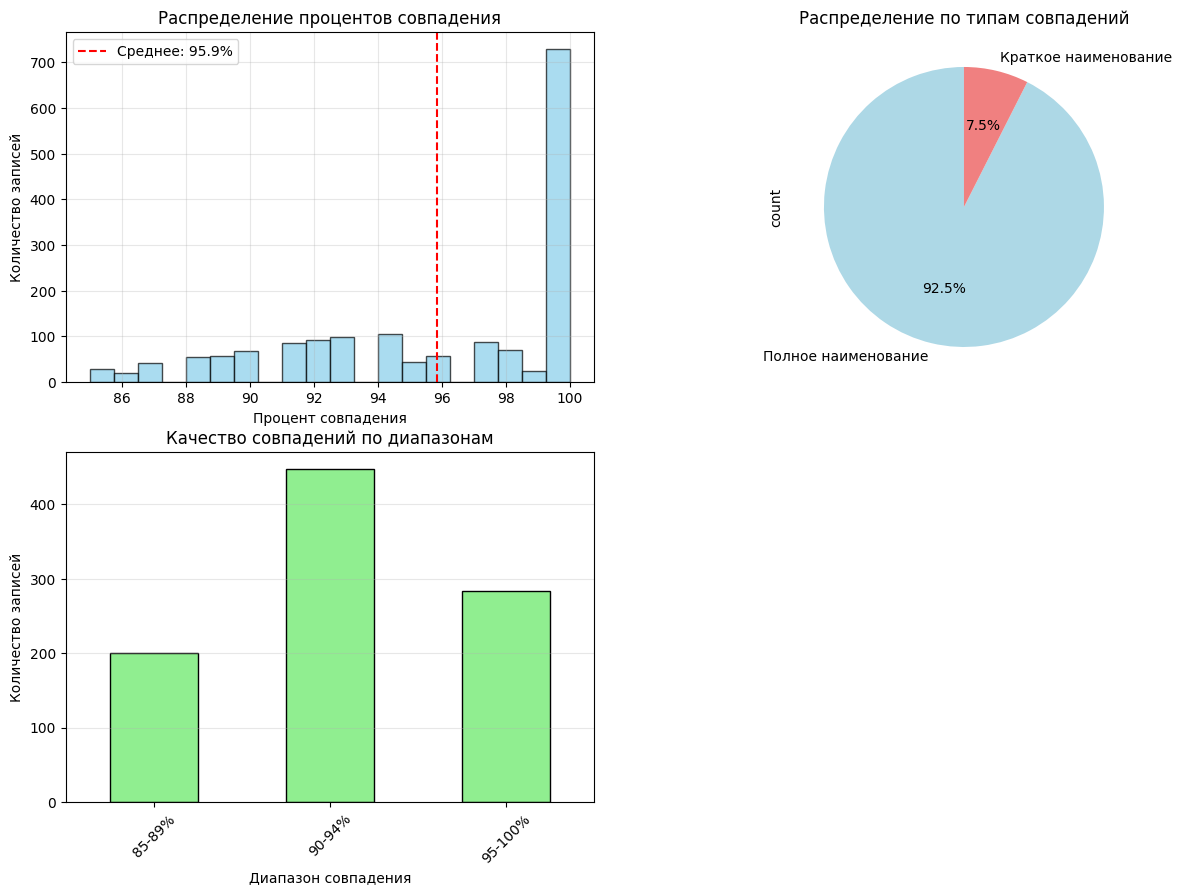

In [49]:
# Нечеткое сравнение несопоставленных записей
print("=== НЕЧЕТКОЕ СРАВНЕНИЕ НЕСОПОСТАВЛЕННЫХ ЗАПИСЕЙ ===")

# Проверяем, что оба датафрейма с несопоставленными записями не пусты
if df_unmatched_etalon is not None and not df_unmatched_etalon.empty and df_unmatched_ksss is not None and not df_unmatched_ksss.empty:
    
    # Устанавливаем библиотеку для нечеткого сравнения
    try:
        import fuzzywuzzy
        from fuzzywuzzy import fuzz, process
        print("fuzzywuzzy успешно импортирован")
    except ImportError:
        print("Устанавливаем fuzzywuzzy...")
        !pip install fuzzywuzzy python-Levenshtein
        import fuzzywuzzy
        from fuzzywuzzy import fuzz, process
        print("fuzzywuzzy успешно установлен и импортирован")
    
    # Создаем копии для безопасной работы
    unmatched_etalon = df_unmatched_etalon.copy()
    unmatched_ksss = df_unmatched_ksss.copy()
    
    # Предварительная обработка данных
    unmatched_etalon['Полное наименование нормализованное'] = unmatched_etalon['Полное наименование нормализованное'].astype(str).str.strip()
    unmatched_etalon['Краткое наименование нормализованное'] = unmatched_etalon['Краткое наименование нормализованное'].astype(str).str.strip()
    unmatched_etalon['Код КССС/id'] = unmatched_etalon['Код КССС/id'].astype(str).str.strip()
    
    unmatched_ksss['FULL_NAME/ru_RU'] = unmatched_ksss['FULL_NAME/ru_RU'].astype(str).str.strip()
    unmatched_ksss['SHORT_NAME/ru_RU'] = unmatched_ksss['SHORT_NAME/ru_RU'].astype(str).str.strip()
    if 'CSCD_ID' in unmatched_ksss.columns:
        unmatched_ksss['CSCD_ID'] = unmatched_ksss['CSCD_ID'].astype(str).str.strip()
    
    # Удаляем пустые наименования из рассмотрения
    unmatched_etalon_full = unmatched_etalon[~unmatched_etalon['Полное наименование нормализованное'].isin(['', 'nan', 'None'])]
    unmatched_etalon_short = unmatched_etalon[~unmatched_etalon['Краткое наименование нормализованное'].isin(['', 'nan', 'None'])]
    
    unmatched_ksss_full = unmatched_ksss[~unmatched_ksss['FULL_NAME/ru_RU'].isin(['', 'nan', 'None'])]
    unmatched_ksss_short = unmatched_ksss[~unmatched_ksss['SHORT_NAME/ru_RU'].isin(['', 'nan', 'None'])]
    
    print(f"Записей для нечеткого сравнения:")
    print(f"  etalon_df с полными наименованиями: {len(unmatched_etalon_full)}")
    print(f"  etalon_df с краткими наименованиями: {len(unmatched_etalon_short)}")
    print(f"  ksss с полными наименованиями: {len(unmatched_ksss_full)}")
    print(f"  ksss с краткими наименованиями: {len(unmatched_ksss_short)}")
    
    # Функция для нечеткого сравнения
    def find_fuzzy_matches(source_df, target_df, source_col, target_col, threshold=80, limit_per_source=3):
      """
      Находит нечеткие соответствия между двумя датафреймами
      """
      matches = []
      
      for idx, source_row in source_df.iterrows():
          source_text = source_row[source_col]
          
          # Ищем лучшие соответствия в целевом датафрейме
          target_texts = target_df[target_col].tolist()
          target_indices = target_df.index.tolist()
          
          # Используем process.extract для поиска лучших соответствий
          best_matches = process.extract(
              source_text, 
              target_texts, 
              limit=limit_per_source, 
              scorer=fuzz.token_sort_ratio
          )
          
          # Сохраняем соответствия выше порога
          for match in best_matches:
              match_text, score = match[0], match[1]  # Извлекаем текст и оценку
              if score >= threshold:
                  # Находим индекс совпадения в исходном списке
                  match_idx = target_texts.index(match_text)
                  target_row = target_df.loc[target_indices[match_idx]]
                  
                  match_data = {
                      'source_index': idx,
                      'target_index': target_indices[match_idx],
                      'source_text': source_text,
                      'target_text': match_text,
                      'similarity_score': score,
                      'source_col': source_col,
                      'target_col': target_col
                  }
                  matches.append(match_data)
      
      return matches
    
    # Параметры нечеткого поиска
    SIMILARITY_THRESHOLD = 85  # Порог схожести (можно настроить)
    MAX_MATCHES_PER_RECORD = 3  # Максимальное количество соответствий на одну запись
    
    print(f"\nНачинаем нечеткое сравнение с порогом {SIMILARITY_THRESHOLD}%...")
    
    # Поиск соответствий по полным наименованиям
    print("Поиск соответствий по полным наименованиям...")
    full_name_matches = find_fuzzy_matches(
        unmatched_etalon_full, 
        unmatched_ksss_full, 
        'Полное наименование нормализованное', 
        'FULL_NAME/ru_RU',
        threshold=SIMILARITY_THRESHOLD,
        limit_per_source=MAX_MATCHES_PER_RECORD
    )
    
    # Поиск соответствий по кратким наименованиям
    print("Поиск соответствий по кратким наименованиям...")
    short_name_matches = find_fuzzy_matches(
        unmatched_etalon_short, 
        unmatched_ksss_short, 
        'Краткое наименование нормализованное', 
        'SHORT_NAME/ru_RU',
        threshold=SIMILARITY_THRESHOLD,
        limit_per_source=MAX_MATCHES_PER_RECORD
    )
    
    # Объединяем все найденные соответствия
    all_matches = full_name_matches + short_name_matches
    
    print(f"\nРЕЗУЛЬТАТЫ НЕЧЕТКОГО СРАВНЕНИЯ:")
    print(f"Найдено соответствий по полным наименованиям: {len(full_name_matches)}")
    print(f"Найдено соответствий по кратким наименованиям: {len(short_name_matches)}")
    print(f"Всего потенциальных соответствий: {len(all_matches)}")
    
    # Создаем датафрейм с частичными соответствиями
    if all_matches:
        # Группируем по исходным записям и выбираем лучшее соответствие для каждой
        best_matches = {}
        
        for match in all_matches:
            source_idx = match['source_index']
            target_idx = match['target_index']
            score = match['similarity_score']
            match_type = 'Полное наименование' if 'Полное' in match['source_col'] else 'Краткое наименование'
            
            key = (source_idx, target_idx)
            if key not in best_matches or score > best_matches[key]['similarity_score']:
                best_matches[key] = {
                    'similarity_score': score,
                    'match_type': match_type,
                    'source_text': match['source_text'],
                    'target_text': match['target_text']
                }
        
        # Создаем финальный датафрейм
        partial_match_records = []
        
        for (source_idx, target_idx), match_info in best_matches.items():
            etalon_row = unmatched_etalon.loc[source_idx]
            ksss_row = unmatched_ksss.loc[target_idx]
            
            record = {
                # Данные из etalon_df
                'Код КССС/id_etalon': etalon_row['Код КССС/id'],
                'Полное наименование нормализованное_etalon': etalon_row['Полное наименование нормализованное'],
                'Краткое наименование нормализованное_etalon': etalon_row['Краткое наименование нормализованное'],
                'Статус_etalon': etalon_row['Статус'],
                'Папка_etalon': etalon_row['Папка'],
                'Имя файла_etalon': etalon_row['Имя файла'],
                
                # Данные из df_ksss_etalon
                'CSCD_ID_ksss': ksss_row.get('CSCD_ID', ''),
                'FULL_NAME/ru_RU_ksss': ksss_row.get('FULL_NAME/ru_RU', ''),
                'SHORT_NAME/ru_RU_ksss': ksss_row.get('SHORT_NAME/ru_RU', ''),
                'TMC_Stat_ksss': ksss_row.get('TMC_Stat', ''),
                'TMC_Type_ksss': ksss_row.get('TMC_Type', ''),
                'COMMENT_ksss': ksss_row.get('COMMENT', ''),
                'AUTO_SHORT_NAME_ksss': ksss_row.get('AUTO_SHORT_NAME', ''),
                'AUTO_FULL_NAME_ksss': ksss_row.get('AUTO_FULL_NAME', ''),
                'Hierarchy_MTR_Class_ksss': ksss_row.get('Hierarchy_MTR_Class', ''),
                'Hierarchy_MTR_Name_ksss': ksss_row.get('Hierarchy_MTR_Name', ''),
                'source_file_ksss': ksss_row.get('source_file', ''),
                
                # Информация о нечетком совпадении
                'Тип_совпадения': match_info['match_type'],
                'Процент_совпадения': match_info['similarity_score'],
                'Сопоставленный_текст_etalon': match_info['source_text'],
                'Сопоставленный_текст_ksss': match_info['target_text']
            }
            partial_match_records.append(record)
        
        df_part_match = pd.DataFrame(partial_match_records)
        
        # Сортируем по проценту совпадения (по убыванию)
        df_part_match = df_part_match.sort_values('Процент_совпадения', ascending=False)
        
        print(f"\nСоздан датафрейм df_part_match с {len(df_part_match)} записями")
        
        # Статистика по качеству совпадений
        print(f"\nСТАТИСТИКА НЕЧЕТКИХ СОВПАДЕНИЙ:")
        print(f"Средний процент совпадения: {df_part_match['Процент_совпадения'].mean():.1f}%")
        print(f"Максимальный процент совпадения: {df_part_match['Процент_совпадения'].max():.1f}%")
        print(f"Минимальный процент совпадения: {df_part_match['Процент_совпадения'].min():.1f}%")
        
        # Распределение по типам совпадений
        match_type_stats = df_part_match['Тип_совпадения'].value_counts()
        print(f"\nРаспределение по типам совпадений:")
        for match_type, count in match_type_stats.items():
            print(f"  {match_type}: {count}")
        
        # Распределение по диапазонам схожести
        print(f"\nРаспределение по качеству совпадений:")
        bins = [85, 90, 95, 100]
        labels = ['85-89%', '90-94%', '95-100%']
        df_part_match['score_range'] = pd.cut(df_part_match['Процент_совпадения'], bins=bins, labels=labels, right=False)
        score_stats = df_part_match['score_range'].value_counts().sort_index()
        for score_range, count in score_stats.items():
            print(f"  {score_range}: {count}")
        
        # Сохраняем в Excel файл
        output_filename = "частичные_совпадения.xlsx"
        df_part_match.to_excel(output_filename, index=False)
        print(f"\nРезультат сохранен в файл: {output_filename}")
        
        # Показываем лучшие совпадения
        print(f"\nТоп-10 лучших совпадений:")
        top_matches = df_part_match.head(10)
        for idx, row in top_matches.iterrows():
            print(f"  {row['Процент_совпадения']}% - {row['Сопоставленный_текст_etalon'][:50]}... -> {row['Сопоставленный_текст_ksss'][:50]}...")
        
        # Визуализация результатов
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        plt.figure(figsize=(15, 10))
        
        # График 1: Распределение процентов совпадения
        plt.subplot(2, 2, 1)
        plt.hist(df_part_match['Процент_совпадения'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(df_part_match['Процент_совпадения'].mean(), color='red', linestyle='--', label=f'Среднее: {df_part_match["Процент_совпадения"].mean():.1f}%')
        plt.xlabel('Процент совпадения')
        plt.ylabel('Количество записей')
        plt.title('Распределение процентов совпадения')
        plt.legend()
        plt.grid(alpha=0.3)
        
        # График 2: Типы совпадений
        plt.subplot(2, 2, 2)
        match_type_stats.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
        plt.title('Распределение по типам совпадений')
        
        # График 3: Качество совпадений по диапазонам
        plt.subplot(2, 2, 3)
        score_stats.plot(kind='bar', color='lightgreen', edgecolor='black')
        plt.title('Качество совпадений по диапазонам')
        plt.xlabel('Диапазон совпадения')
        plt.ylabel('Количество записей')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        

        
        # Показываем полный датафрейм
        print(f"\nПолный датафрейм df_part_match ({len(df_part_match)} записей):")
        display(df_part_match.head(15))
        
    else:
        print("Нечеткие соответствия не найдены!")
        df_part_match = pd.DataFrame()

else:
    print("Один или оба датафрейма с несопоставленными записями пусты!")
    df_part_match = pd.DataFrame()